# Generative models

## Load Q K V matrices (pre-trained)

In [33]:
import numpy as np
import torch
from model import AttentionModel
from attention import trainer
from dcascore import *
import os
import random


cwd = os.getcwd()
cwd=cwd.replace(r"\CODE\AttentionDCA_python\src",'')
cwd="C"+cwd[1:]
def read_tensor_from_txt(filename):
    with open(filename, 'r') as f:
        lines = f.readlines()

    # Read the dimensions from the first line
    dims = list(map(int, lines[0].strip().split()))
    
    tensor_data = []
    current_slice = []
    for line in lines[1:]:
        line = line.strip()
        if line.startswith("Slice"):
            if current_slice:
                tensor_data.append(current_slice)
                current_slice = []
        elif line:
            current_slice.append(list(map(float, line.split(','))))
    if current_slice:
        tensor_data.append(current_slice)

    tensor = torch.tensor(tensor_data).view(*dims)
    return tensor
def set_seed(seed=0):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
set_seed()
H = 64
d= 10
N = 174
n_epochs = 500
loss_type = 'without_J'
family = 'jdoms' #'jdoms_bacteria_train2'
cwd = '/Users/marzioformica/Desktop/EPFL/Master/MA2/Labo/my_project/PLM-gen-DCA/Attention-DCA-main/CODE/AttentionDCA_python/src'
Q_1 = read_tensor_from_txt( cwd +"/results/{H}_{d}_{family}_{losstype}_{n_epochs}_youss/K_tensor.txt".format(H=H, d=d, family=family, losstype=loss_type, n_epochs=n_epochs))
K_1 = read_tensor_from_txt( cwd +"/results/{H}_{d}_{family}_{losstype}_{n_epochs}_youss/Q_tensor.txt".format(H=H, d=d, family=family, losstype=loss_type, n_epochs=n_epochs))
V_1 = read_tensor_from_txt( cwd +"/results/{H}_{d}_{family}_{losstype}_{n_epochs}_youss/V_tensor.txt".format(H=H, d=d, family=family, losstype=loss_type, n_epochs=n_epochs))



H,d,N=Q_1.shape
q=V_1.shape[1]
print(Q_1.shape)
print(V_1.shape)



torch.Size([64, 10, 63])
torch.Size([64, 21, 21])


### Access sequences - test

In [34]:
cwd = '/Users/marzioformica/Desktop/EPFL/Master/MA2/Labo/my_project/PLM-gen-DCA/Attention-DCA-main'
family = 'jdoms_bacteria_train2'
filename = cwd + f'/CODE/DataAttentionDCA/jdoms/{family}.fasta'
structfile = cwd + '/CODE/DataAttentionDCA/jdoms/jdom.dat'
file_path = filename
def read_fasta(file_path):
    with open(file_path, "r") as file:
        for line in file:
            print(line.strip())  # Strip removes extra whitespace


def sequence_from_fasta(file_path):
    sequences = []
    with open(file_path, "r") as file:
        sequence = ''
        for line in file:
            line = line.strip()
            if line.startswith(">"):  # Ignore headers
                if sequence:  # If there's a previous sequence, add it to the list
                    sequences.append(sequence)
                sequence = ''  # Reset sequence for the next one
            else:
                sequence += line  # Add the line to the current sequence
        if sequence:  # Append the last sequence
            sequences.append(sequence)
    return sequences

true_sequences = sequence_from_fasta(file_path)
true_seq = true_sequences[10]

letter_to_num = {
    'A': 1,  'B': 21, 'C': 2,  'D': 3,  'E': 4,
    'F': 5,  'G': 6,  'H': 7,  'I': 8,  'J': 21,
    'K': 9,  'L': 10, 'M': 11, 'N': 12, 'O': 21,
    'P': 13, 'Q': 14, 'R': 15, 'S': 16, 'T': 17,
    'U': 21, 'V': 18, 'W': 19, 'X': 21, 'Y': 20,
    '-': 21  # Gap symbol
}

def convert_sequence_to_numbers(sequence):
    letter_to_num = {
    'A': 1,  'B': 21, 'C': 2,  'D': 3,  'E': 4,
    'F': 5,  'G': 6,  'H': 7,  'I': 8,  'J': 21,
    'K': 9,  'L': 10, 'M': 11, 'N': 12, 'O': 21,
    'P': 13, 'Q': 14, 'R': 15, 'S': 16, 'T': 17,
    'U': 21, 'V': 18, 'W': 19, 'X': 21, 'Y': 20,
    '-': 21  # Gap symbol
    }
    return np.array([letter_to_num.get(aa, 21) for aa in sequence])

num_seq = convert_sequence_to_numbers(true_seq)
print(num_seq)

# Example usage
#read_fasta(filename)

[ 3 20 20 14 18 10  6 18 13  9  3  1  3  1  9 16  8  9  9  1  5 15  9 10
  1 15  9 20  7 13  3 18 12 13  6  3  9  4  1  4 15  9  5  9  4  1 12  4
  1 12  4 18 10 16  3 13  4  9 15  9  9 20  3]


## Get coupling tensor J from Q, K, V

In [35]:
model=AttentionModel(H,d,N,q,Q_1,K_1,V_1)
#torch.sum(model.Q-Q_1)
device = Q_1.device
L = Q_1.shape[-1]
W=attention_heads_from_model(model,Q_1,K_1,V_1)
print(W.shape)

i_indices = torch.arange(L, device=device).unsqueeze(1)
j_indices = torch.arange(L, device=device).unsqueeze(0)
mask = (i_indices != j_indices).float().unsqueeze(0)  # shape (1, L, L)
W = W * mask
    
# Compute Jtens
Jtens = torch.einsum('hri,hab->abri', W, V_1)  # Shape: (q, q, L, L)
q = Jtens.shape[0]
N = Jtens.shape[2]
print(q)
print(N)

#ranking,JT_np=score(model,Q_1,K_1,V_1)

print(Jtens.shape)


torch.Size([64, 63, 63])
21
63
torch.Size([21, 21, 63, 63])


# AR gen

In [20]:
letter_to_num = {
    'A': 1,  'B': 21, 'C': 2,  'D': 3,  'E': 4,
    'F': 5,  'G': 6,  'H': 7,  'I': 8,  'J': 21,
    'K': 9,  'L': 10, 'M': 11, 'N': 12, 'O': 21,
    'P': 13, 'Q': 14, 'R': 15, 'S': 16, 'T': 17,
    'U': 21, 'V': 18, 'W': 19, 'X': 21, 'Y': 20,
    '-': 21  # Gap symbol
}


def prob_cond_unnormalized(aa,prev_aa,J_ten):
    i=len(prev_aa)
    sum=0
    for j in range(i-1):
        sum+=J_ten[letter_to_num[aa],letter_to_num[prev_aa[j]],i-1,j]
    return np.exp(sum)
def Z_i_prob(aa_pot,prev_aa,J_tens):
    list_prob=[prob_cond_unnormalized(aa,prev_aa,J_tens) for aa in aa_pot ]
    return list_prob
def sample(aa_pot,Z_list):
    Z=np.sum(Z_list)
    Z_list=Z_list/Z
    return np.random.choice(aa_pot,p=Z_list)


def generate_sequence(aa_pot,J):
    L=J.shape[-1]
    aa_sequence=[]
    aa_sequence.append(np.random.choice(aa_pot))
    for i in range(L):
        Z_list=Z_i_prob(aa_pot,aa_sequence,J)
        aa_sequence.append(sample(aa_pot,Z_list))
    return aa_sequence

#à verifier confusion entre lettres et nombre dans les samples et les listes à la fin


    

# PLM gen

In [49]:
num_to_letter = {v: k for k, v in letter_to_num.items()}

class SequencePLM:
    def __init__(self, J):
        self.J = J
        self.L = J.shape[-1]
        self.sequence = np.random.choice(np.arange(21), self.L)  # ints from 1 to 21

    def to_letter(self):
        letter_to_num = {
        'A': 0,  'C': 1,  'D': 2,  'E': 3,
        'F': 4,  'G': 5,  'H': 6,  'I': 7,  
        'K': 8,  'L': 9, 'M': 10, 'N': 11, 
        'P': 12, 'Q': 13, 'R': 14, 'S': 15, 'T': 16,
        'V': 17, 'W': 18,  'Y': 19,
        '-': 20  # Gap symbol
        }

        num_to_letter = {v: k for k, v in letter_to_num.items()}

        # Convert sequence using safe lookup (defaults to 'X' if index not found)
        letter_seq = ''.join([num_to_letter.get(i, 'X') for i in self.sequence])
        print(letter_seq)
        return letter_seq

    def plm_calc(self, site, trial_aa):
        """
        Compute unnormalized pseudo-likelihood of trial_aa at a given site.
        
        site: int from 0 to L-1
        trial_aa: int from 0 to 21 (amino acid index)
        """
        sum_energy = 0.0
        for j in range(self.L):
            if j == site:
                continue
            aa_j = self.sequence[j]
            sum_energy += self.J[trial_aa, aa_j, site, j] # check indexing
        prob = np.exp(sum_energy)  # unnormalized
        return prob
    
    def plm_site_distribution(self, site):
        """
        Compute probability distriution for specific site (normalized)
        """
        probs = []
        for trial_aa in range(21):
            probs.append(self.plm_calc(site, trial_aa))
        probs = np.array(probs)
        probs /= probs.sum()
        return probs
    
    def plm_site_distribution_vectorized(self, site):
        """
        Efficiently compute normalized PLM distribution over amino acids at a given site.
        """
        # Get current amino acid sequence at all positions except the target site
        other_sites = np.delete(np.arange(self.L), site)
        aa_other = self.sequence[other_sites]  # shape: (L-1,)
        
        # Extract J slice relevant to the target site
        # shape: (22, 22, L, L) → we want (22, L-1)
        J_slice = self.J[:, aa_other, site, other_sites]  # shape: (22, L-1)
        
        # Sum over interactions to compute energy per possible amino acid
        sum_energy = np.sum(J_slice, axis=1)  # shape: (22,)
        
        # Compute unnormalized probabilities
        probs = np.exp(sum_energy)
        
        # Normalize to get the PLM distribution
        probs /= probs.sum()
    
        return probs
    
    def draw_aa(self, site):
        """
        Sample a new AA at the given site from PLM distribution
        """
        probs = self.plm_site_distribution(site)
        new_aa = np.random.choice(np.arange(21), p=probs)
        self.sequence[site] = new_aa
        

In [61]:
from tqdm import tqdm

#def generate_plm(J,maxiter=10000):
#    """
#    function to generate new sequence using PLM
#    """
#    gen_sequences = []
#    seq = SequencePLM(J)
#    for _ in tqdm(range(maxiter)):
#        site = np.random.randint(seq.L)  # Random site from 0 to L-1
#        seq.draw_aa(site)
#        gen_sequences.append(seq.sequence.copy())
#    gen_sequences = np.array(gen_sequences)
#    return gen_sequences

def generate_plm(J, maxiter=10000):
    """
    Function to generate new sequence using PLM
    """
    gen_sequences = []
    seq = SequencePLM(J)
    
    for i in tqdm(range(maxiter)):
        site = np.random.randint(seq.L)  # Random site from 0 to L-1
        seq.draw_aa(site)
        gen_sequences.append(seq.sequence.copy())
        
        # Print the sequence as letters every 1000 iterations
        if (i + 1) % 1000 == 0:
            print(f"Step {i + 1}: {seq.to_letter()}")

    gen_sequences = np.array(gen_sequences)
    return gen_sequences

gen_sequences = []
#for _ in range(100):
#    seq = generate_plm(Jtens)
#    gen_sequences.append(seq.sequence)
gen_sequences = generate_plm(Jtens, 40000)

num_to_letter = {v: k for k, v in letter_to_num.items()}

print(np.shape(gen_sequences))

  0%|          | 0/40000 [00:00<?, ?it/s]/var/folders/dv/fpf7xq8j6yzfxjs7g9c_bbyc0000gn/T/ipykernel_59969/3653463909.py:39: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  prob = np.exp(sum_energy)  # unnormalized
  3%|▎         | 1012/40000 [00:13<08:00, 81.08it/s]

-PFNVDKVLNAPKNKLMNELNLN-SGDEDTEDKFNDSQVEGAACMFSSWFGRRNAIQSWIVFN
Step 1000: -PFNVDKVLNAPKNKLMNELNLN-SGDEDTEDKFNDSQVEGAACMFSSWFGRRNAIQSWIVFN


  5%|▌         | 2010/40000 [00:25<07:57, 79.60it/s]

RRARDDPALFHRFHAQQCAFYADARRYP-KAAWANR-RPTPCAEKQTALVRVPEDSMAIMAVR
Step 2000: RRARDDPALFHRFHAQQCAFYADARRYP-KAAWANR-RPTPCAEKQTALVRVPEDSMAIMAVR


  8%|▊         | 3015/40000 [00:39<08:10, 75.42it/s]

KYNDLSITNALE-DTDEKSQAYFVFHTAIGKKAFVYESKPDTPEEGRIEYLKDQKKYCFEIVE
Step 3000: KYNDLSITNALE-DTDEKSQAYFVFHTAIGKKAFVYESKPDTPEEGRIEYLKDQKKYCFEIVE


 10%|█         | 4012/40000 [00:51<07:14, 82.74it/s]

QISFRG-AVEAATHANRQIEIARKSRWDMQLQSKVRPQQQYQVRNYERRDN-CLEL-QNATDE
Step 4000: QISFRG-AVEAATHANRQIEIARKSRWDMQLQSKVRPQQQYQVRNYERRDN-CLEL-QNATDE


 13%|█▎        | 5012/40000 [01:05<07:49, 74.46it/s]

-----LMAHLCT-DENTH-R-ID-KKSDDPA-DDSSN---MGTRARSANFAA-EREANEKSVI
Step 5000: -----LMAHLCT-DENTH-R-ID-KKSDDPA-DDSSN---MGTRARSANFAA-EREANEKSVI


 15%|█▌        | 6014/40000 [01:18<07:05, 79.85it/s]

--FFRKEDIDQNQ-FGNWVQILN-QRFMSALLYDTLAAQQVFAEFFWFPALHKRSLRQLEAPW
Step 6000: --FFRKEDIDQNQ-FGNWVQILN-QRFMSALLYDTLAAQQVFAEFFWFPALHKRSLRQLEAPW


 18%|█▊        | 7014/40000 [01:30<07:00, 78.40it/s]

PEAPFQMFFAVFNYIVIRFPAARNNVYLLGAVQISKLPFSGQINPSLTPMFPPYPFHTRLNKS
Step 7000: PEAPFQMFFAVFNYIVIRFPAARNNVYLLGAVQISKLPFSGQINPSLTPMFPPYPFHTRLNKS


 20%|██        | 8016/40000 [01:43<06:18, 84.60it/s]

GLADEPLLTKMQIREQRSLISLRDPVNKKV-NETCTRFNDDTAQVRVK-RMQLSKRYHSEDAR
Step 8000: GLADEPLLTKMQIREQRSLISLRDPVNKKV-NETCTRFNDDTAQVRVK-RMQLSKRYHSEDAR


 23%|██▎       | 9015/40000 [01:55<06:10, 83.58it/s]

------L-MNHKEVHRGPWL-KRTLDK-NKD-AELV-D-VDKVYWAPVV-DT-R-D-HYDCPV
Step 9000: ------L-MNHKEVHRGPWL-KRTLDK-NKD-AELV-D-VDKVYWAPVV-DT-R-D-HYDCPV


 25%|██▌       | 10015/40000 [02:07<06:20, 78.81it/s]

APDSTERTESDLRSKRDADDRFRYDDQERGSMFAVKPAEALDNDR-PKPHDEWYVRISFDNRV
Step 10000: APDSTERTESDLRSKRDADDRFRYDDQERGSMFAVKPAEALDNDR-PKPHDEWYVRISFDNRV


 28%|██▊       | 11014/40000 [02:20<05:48, 83.11it/s]

NRPGMP-LTGLR-L-MLALREIDFRDRPPTHLWRTNQIDSTIEQAAAAAPPRRSPADPIYVER
Step 11000: NRPGMP-LTGLR-L-MLALREIDFRDRPPTHLWRTNQIDSTIEQAAAAAPPRRSPADPIYVER


 30%|███       | 12013/40000 [02:33<06:22, 73.09it/s]

ESARTRALRPWYIHNMARDSLEDAAQRANPTWGPSRNKRADSMELAANNMFQLAAN-TRPARE
Step 12000: ESARTRALRPWYIHNMARDSLEDAAQRANPTWGPSRNKRADSMELAANNMFQLAAN-TRPARE


 33%|███▎      | 13008/40000 [02:47<05:40, 79.20it/s]

ALDEADRDPAA-RYFDGQRTS--KSREEDLEPDRAADAHIKE--VEAQRR--EASHHPSPDAL
Step 13000: ALDEADRDPAA-RYFDGQRTS--KSREEDLEPDRAADAHIKE--VEAQRR--EASHHPSPDAL


 35%|███▌      | 14015/40000 [03:00<06:09, 70.31it/s]

HELVAHDEEARFMAGRSKASLNLVTRYAHRALENLADPEEVAQMVRGVDFRDYAILKMQAANR
Step 14000: HELVAHDEEARFMAGRSKASLNLVTRYAHRALENLADPEEVAQMVRGVDFRDYAILKMQAANR


 38%|███▊      | 15009/40000 [03:12<05:35, 74.53it/s]

AKFSIFVEEAATADEDAAGPP-SKKAVDILAAGTDD-VVATL-DRGGREA-SDGTRDLAEVLE
Step 15000: AKFSIFVEEAATADEDAAGPP-SKKAVDILAAGTDD-VVATL-DRGGREA-SDGTRDLAEVLE


 40%|████      | 16007/40000 [03:26<05:22, 74.48it/s]

ARHMV-AELIFKAIRMIDGIQDFNAHA-GAHSPITSFAYHHVEASNEVHNKPNKNDLLA-ART
Step 16000: ARHMV-AELIFKAIRMIDGIQDFNAHA-GAHSPITSFAYHHVEASNEVHNKPNKNDLLA-ART


 43%|████▎     | 17009/40000 [03:39<05:12, 73.59it/s]

-QTPPQTRKCDD-FRETHNGNDRSSIAVTKYDAPLRALRDAPFTRPHRTFVWNDLPSFKSTKF
Step 17000: -QTPPQTRKCDD-FRETHNGNDRSSIAVTKYDAPLRALRDAPFTRPHRTFVWNDLPSFKSTKF


 45%|████▌     | 18008/40000 [03:52<05:08, 71.31it/s]

GATKPPESHLEPASPPIASAEVYTEKQDYGYV-PVRKQKHLREHETQFYKPNKDNAS--GRKK
Step 18000: GATKPPESHLEPASPPIASAEVYTEKQDYGYV-PVRKQKHLREHETQFYKPNKDNAS--GRKK


 48%|████▊     | 19014/40000 [04:06<04:27, 78.54it/s]

LM-GRKLEGQLMMQYAK-LTKNV-EDLQLQKPIEKADTEAAAKDTENAEKAEKVQAFGG-SEF
Step 19000: LM-GRKLEGQLMMQYAK-LTKNV-EDLQLQKPIEKADTEAAAKDTENAEKAEKVQAFGG-SEF


 50%|█████     | 20009/40000 [04:19<04:06, 81.17it/s]

SDVAKQCVK--QDCTFIAESIHQVKNSQQQDKFNQHRRDKMARVR-DENLAFYHFAKHINQHL
Step 20000: SDVAKQCVK--QDCTFIAESIHQVKNSQQQDKFNQHRRDKMARVR-DENLAFYHFAKHINQHL


 53%|█████▎    | 21011/40000 [04:32<04:32, 69.61it/s]

FKALPGASGFNYWNL-LLYLEHVKRQRDCLEKLTLSQLETHSEEKTIVNLSYAKGDNDNTASF
Step 21000: FKALPGASGFNYWNL-LLYLEHVKRQRDCLEKLTLSQLETHSEEKTIVNLSYAKGDNDNTASF


 55%|█████▌    | 22009/40000 [04:45<03:40, 81.63it/s]

AAWKFLRMHNVGMN-YPLAHFYAQNVEK-NLNDADAKQ-TRDEPNPKNERNQSVKADENYPEQ
Step 22000: AAWKFLRMHNVGMN-YPLAHFYAQNVEK-NLNDADAKQ-TRDEPNPKNERNQSVKADENYPEQ


 58%|█████▊    | 23010/40000 [04:58<03:41, 76.62it/s]

AVVRQQSDRRHLNSPLSETVRINTHVHPSLPQAQVAIKMDHESSVVPWSDMRMTQKHHDPLEE
Step 23000: AVVRQQSDRRHLNSPLSETVRINTHVHPSLPQAQVAIKMDHESSVVPWSDMRMTQKHHDPLEE


 60%|██████    | 24013/40000 [05:10<03:18, 80.67it/s]

KATREALSLTEQRHERPADETNDALVSKSVPDRAAAHANYYSLQMRRERYVYLPPDWLRRSKL
Step 24000: KATREALSLTEQRHERPADETNDALVSKSVPDRAAAHANYYSLQMRRERYVYLPPDWLRRSKL


 63%|██████▎   | 25008/40000 [05:24<03:21, 74.46it/s]

DAIYLHVR-LAPPVLFFINDFKHA-QRRSYFLAPIEMVVWPIWVEWESKTRPELEATRAIEFM
Step 25000: DAIYLHVR-LAPPVLFFINDFKHA-QRRSYFLAPIEMVVWPIWVEWESKTRPELEATRAIEFM


 65%|██████▌   | 26011/40000 [05:37<03:20, 69.68it/s]

QWLDTKSNDKDMSADNRKLTNKRDHRRRQNRVLRESEAHLQQSEMHHVIINVQEKEFLSLIRR
Step 26000: QWLDTKSNDKDMSADNRKLTNKRDHRRRQNRVLRESEAHLQQSEMHHVIINVQEKEFLSLIRR


 68%|██████▊   | 27008/40000 [05:50<02:45, 78.72it/s]

KKGEKKYDE-E-PE-HLVECVKRIRYKILKLPKEYMETPIQHEYHYI-TGFHVPFTLWGDKAQ
Step 27000: KKGEKKYDE-E-PE-HLVECVKRIRYKILKLPKEYMETPIQHEYHYI-TGFHVPFTLWGDKAQ


 70%|███████   | 28008/40000 [06:04<02:34, 77.56it/s]

PDYSATETTLRVEQRISGFMTDLVMSIKRDRKPLARSSLGASKTDSAYKMKRRARELKEYPEE
Step 28000: PDYSATETTLRVEQRISGFMTDLVMSIKRDRKPLARSSLGASKTDSAYKMKRRARELKEYPEE


 73%|███████▎  | 29013/40000 [06:17<02:31, 72.34it/s]

CKGMEGKEAIHPLEVEDPMDEMPCSPFSKSPKWGYNLAIAENPRNPPKKVILGKIQEKRCHTA
Step 29000: CKGMEGKEAIHPLEVEDPMDEMPCSPFSKSPKWGYNLAIAENPRNPPKKVILGKIQEKRCHTA


 75%|███████▌  | 30012/40000 [06:29<01:57, 84.99it/s]

TASLNILPFLKQFFDLEAAKNSSEFISALDKYKFDLSGE-AVNLVYIKS-SISRKERDEEALR
Step 30000: TASLNILPFLKQFFDLEAAKNSSEFISALDKYKFDLSGE-AVNLVYIKS-SISRKERDEEALR


 78%|███████▊  | 31009/40000 [06:41<01:46, 84.16it/s]

KDKSEADKKARREPGNYKNPRDELKKQKDRYKSHYKLFKRFHMLKDDDT-R-RLKQMDTPLKK
Step 31000: KDKSEADKKARREPGNYKNPRDELKKQKDRYKSHYKLFKRFHMLKDDDT-R-RLKQMDTPLKK


 80%|████████  | 32012/40000 [06:54<01:36, 83.00it/s]

EVNHPER-RPHIHPWTPLRSSVRWRNREEPRSVVIHIVYNADDTPFAQPTMIAELHKNTRLAG
Step 32000: EVNHPER-RPHIHPWTPLRSSVRWRNREEPRSVVIHIVYNADDTPFAQPTMIAELHKNTRLAG


 83%|████████▎ | 33011/40000 [07:06<01:22, 84.36it/s]

KKENSKTLKARQV-SL-LNQMRIRH-AYRDIVRELLSKSRKENLDVVIQKKRLGKLIDDNQIA
Step 33000: KKENSKTLKARQV-SL-LNQMRIRH-AYRDIVRELLSKSRKENLDVVIQKKRLGKLIDDNQIA


 85%|████████▌ | 34014/40000 [07:18<01:11, 83.74it/s]

AHLRVALRVRAQLASQRGWNDEIKE-D-GRQDDANQMAQARKQKLTDDAKRSDDRAAKLHQDT
Step 34000: AHLRVALRVRAQLASQRGWNDEIKE-D-GRQDDANQMAQARKQKLTDDAKRSDDRAAKLHQDT


 88%|████████▊ | 35015/40000 [07:31<01:03, 78.21it/s]

NLRSVHRLMAKANLRYAMKALAGGEAYARTLTLGG-ARKFEYLLVADELRRVACRAKAPRWNF
Step 35000: NLRSVHRLMAKANLRYAMKALAGGEAYARTLTLGG-ARKFEYLLVADELRRVACRAKAPRWNF


 90%|█████████ | 36015/40000 [07:43<00:47, 84.14it/s]

FDIKATDRAEWAHYNDASNAS-MAAFTKRNSQSLRPRSKYNAFAPNEEAQEAADSHLEFR-LF
Step 36000: FDIKATDRAEWAHYNDASNAS-MAAFTKRNSQSLRPRSKYNAFAPNEEAQEAADSHLEFR-LF


 93%|█████████▎| 37008/40000 [07:57<00:37, 79.31it/s]

RRHLAKLFKHVEHGRYGESIWAKTLHTAHII-VAAML-PTLAKRFVLLPLFQYYHARSVSTIF
Step 37000: RRHLAKLFKHVEHGRYGESIWAKTLHTAHII-VAAML-PTLAKRFVLLPLFQYYHARSVSTIF


 95%|█████████▌| 38008/40000 [08:10<00:24, 81.06it/s]

RVITKENESHWLYEEKILLG-NYQQLKVNLLLSGFVTL-RTIKERYFQELYTGKASNSYTEIR
Step 38000: RVITKENESHWLYEEKILLG-NYQQLKVNLLLSGFVTL-RTIKERYFQELYTGKASNSYTEIR


 98%|█████████▊| 39009/40000 [08:22<00:11, 83.85it/s]

LGDYIGLMAQDRQDQLTAFNVVAPPAQAFAYVLTLQAIILCSTRD-EVGALHTKGNQYLQTQL
Step 39000: LGDYIGLMAQDRQDQLTAFNVVAPPAQAFAYVLTLQAIILCSTRD-EVGALHTKGNQYLQTQL


100%|██████████| 40000/40000 [08:34<00:00, 77.75it/s]

DKKISSNQQCSSRKSDRNNLLNLFTKGQLPETAHHKASNLSNSQVQKRNYAEKLPDQALITDI
Step 40000: DKKISSNQQCSSRKSDRNNLLNLFTKGQLPETAHHKASNLSNSQVQKRNYAEKLPDQALITDI
(40000, 63)


### PLM test

/var/folders/dv/fpf7xq8j6yzfxjs7g9c_bbyc0000gn/T/ipykernel_59969/3515059638.py:39: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  prob = np.exp(sum_energy)  # unnormalized


[ 7  8 12  6 18 21 10  1  7 20  8 19  7  4  6 10  6 17  7 12 18 21  8 19
 11  7  5  8 16 14  4  7 12  8 12 17  5 19 12 20  3 17 10  6  9 18 17 13
  6 19 13  2 11  4 17  7  1  8  4 21  5 13 18]
HINGV-LAHYIWHEGLGTHNV-IWMHFISQEHNINTFWNYDTLGKVTPGWPCMETHAIE-FPV
Initial seq: HINGV-LAHYIWHEGLGTHNV-IWMHFISQEHNINTFWNYDTLGKVTPGWPCMETHAIE-FPV
site: 54
Proba distribution for site 54 : [0.11045279 0.02264714 0.0496503  0.02354423 0.03241944 0.01455431
 0.0688585  0.05438323 0.09813988 0.04853347 0.02402378 0.01592591
 0.0140084  0.02758038 0.11912116 0.05954284 0.03505089 0.03078158
 0.01912029 0.07425699 0.05740456]


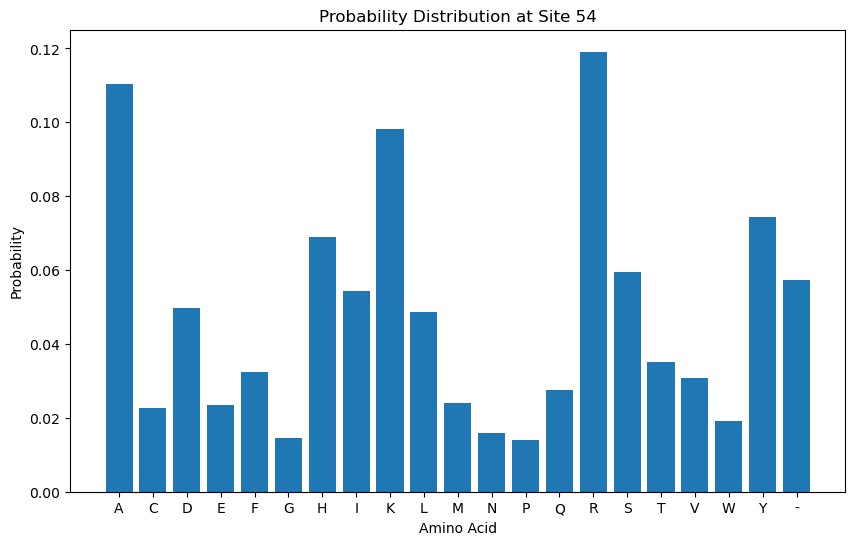

/var/folders/dv/fpf7xq8j6yzfxjs7g9c_bbyc0000gn/T/ipykernel_59969/3515059638.py:39: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  prob = np.exp(sum_energy)  # unnormalized


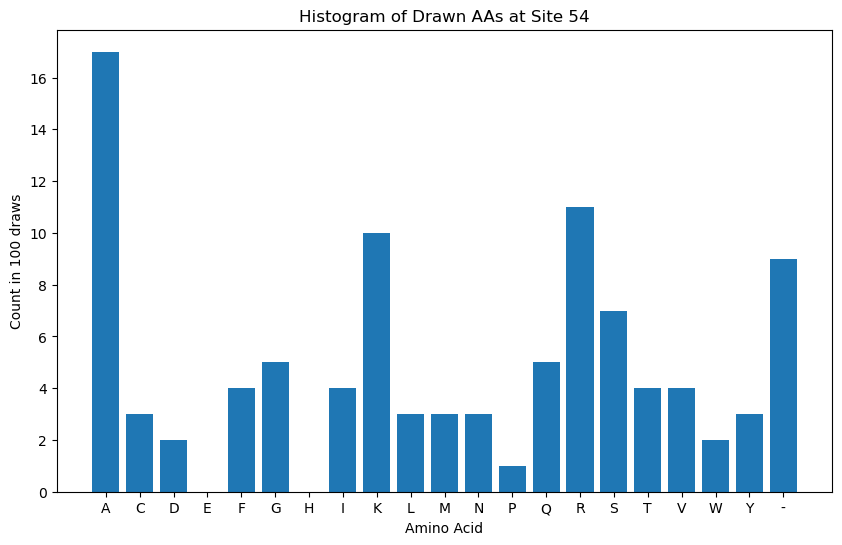

In [23]:
seq = SequencePLM(Jtens)
print(seq.sequence)
print("Initial seq:", seq.to_letter())
site = np.random.randint(seq.L)  # Random site from 0 to L-1
print("site:", site)
print("Proba distribution for site", site, ":", seq.plm_site_distribution(site))
# Plot distribution
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.bar(range(1,22), seq.plm_site_distribution(site))
plt.xticks(range(1,22), [num_to_letter[i] for i in range(1,22)])
plt.xlabel('Amino Acid')
plt.ylabel('Probability')
plt.title(f'Probability Distribution at Site {site}')
plt.show()    


N = 100
drawn_aas = []
for i in range(N):
    seq.draw_aa(site)
    aa = seq.sequence[site]
    #print(aa)
    drawn_aas.append(aa)
    #print("New aa at site", site, "on draw", i, ":", num_to_letter[aa])
# Count occurrences of each amino acid ID (1 to 21)
aa_ids = np.arange(1, 22)
frequencies = [drawn_aas.count(i) for i in aa_ids]  # Pure Python count

# Plot
plt.figure(figsize=(10, 6))
plt.bar(aa_ids, frequencies)
plt.xticks(aa_ids, [num_to_letter[i] for i in aa_ids])
plt.xlabel('Amino Acid')
plt.ylabel('Count in 100 draws')
plt.title(f'Histogram of Drawn AAs at Site {site}')
plt.show()



/var/folders/dv/fpf7xq8j6yzfxjs7g9c_bbyc0000gn/T/ipykernel_59969/3515059638.py:39: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  prob = np.exp(sum_energy)  # unnormalized


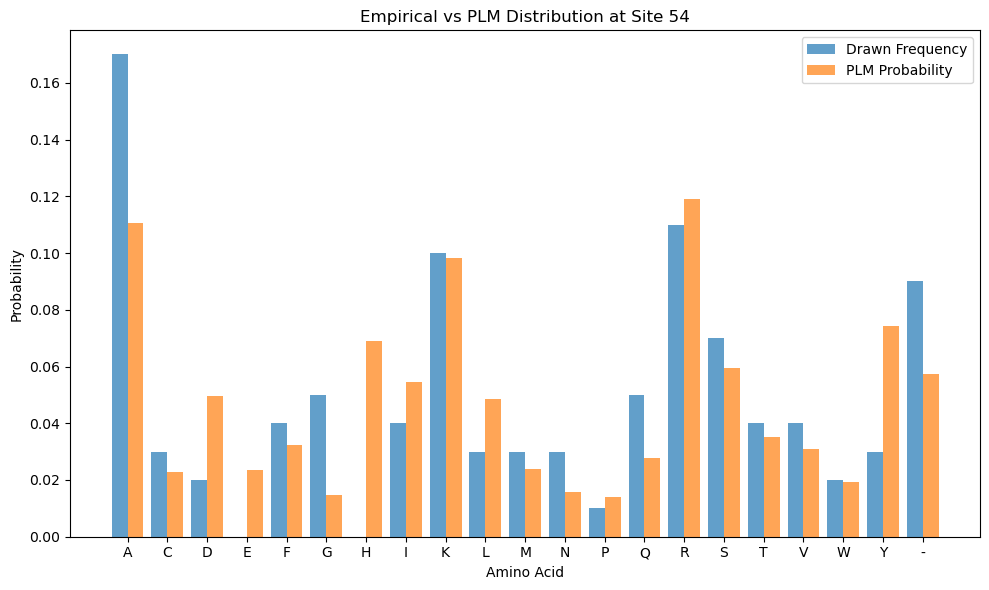

In [24]:
import numpy as np
import matplotlib.pyplot as plt

# Get empirical frequencies
aa_ids = np.arange(1, 22)
empirical_freqs = [drawn_aas.count(i) / len(drawn_aas) for i in aa_ids]  # Normalize to probability

# Get PLM probabilities at the site
plm_probs = seq.plm_site_distribution(site)

# Plot both
plt.figure(figsize=(10, 6))
bar_width = 0.4

# Bar plot for empirical frequencies
plt.bar(aa_ids - bar_width/2, empirical_freqs, width=bar_width, label='Drawn Frequency', alpha=0.7)

# Bar plot for PLM distribution
plt.bar(aa_ids + bar_width/2, plm_probs, width=bar_width, label='PLM Probability', alpha=0.7)

# X-axis labels
plt.xticks(aa_ids, [num_to_letter[i] for i in aa_ids])
plt.xlabel('Amino Acid')
plt.ylabel('Probability')
plt.title(f'Empirical vs PLM Distribution at Site {site}')
plt.legend()
plt.tight_layout()
plt.show()


Original sequence: DYYQVLGVPKDADAKSIKKAFRKLARKYHPDVNPGDKEAERKFKEANEANEVLSDPEKRKKYD
Numerical sequence: [ 3 20 20 14 18 10  6 18 13  9  3  1  3  1  9 16  8  9  9  1  5 15  9 10
  1 15  9 20  7 13  3 18 12 13  6  3  9  4  1  4 15  9  5  9  4  1 12  4
  1 12  4 18 10 16  3 13  4  9 15  9  9 20  3]
Random site selected: 29 with amino acid (letter): P
E--RWMHWQLECECLTKLLCGSLMCSL-IQEWPQHELFCFSLGLFCPFCPFWMTEQFLSLL-E
Initial seq: E--RWMHWQLECECLTKLLCGSLMCSL-IQEWPQHELFCFSLGLFCPFCPFWMTEQFLSLL-E
True amino acid at site: P


/var/folders/dv/fpf7xq8j6yzfxjs7g9c_bbyc0000gn/T/ipykernel_59969/3653463909.py:39: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  prob = np.exp(sum_energy)  # unnormalized


The original sequence was drawn 7 times out of 100.


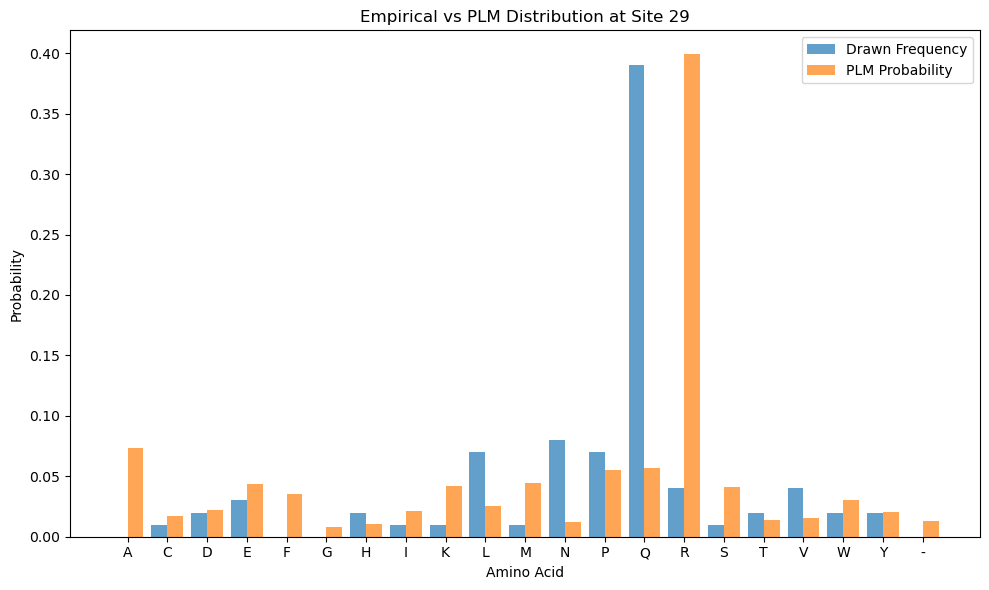

In [51]:
import matplotlib.pyplot as plt

# Assuming the convert_sequence_to_numbers and SequencePLM classes are already defined as in previous code

# Convert sequence to numerical representation
true_seq_nb = convert_sequence_to_numbers(true_seq)
print("Original sequence:", true_seq)
print("Numerical sequence:", true_seq_nb)

# Select a random site
site = np.random.randint(seq.L)  # Random site from 0 to L-1
site = 29
print("Random site selected:", site, "with amino acid (letter):", num_to_letter[true_seq_nb[site]])

# Initialize the SequencePLM object and set the sequence
seq = SequencePLM(Jtens)
seq.sequence = true_seq_nb.copy()

print("Initial seq:", seq.to_letter())
print("True amino acid at site:", true_seq[site])

# Sampling new amino acids at the given site
N = 100
drawn_aas = []
drawn_sequences = []
original_seq_count = 0  # To count how many times the original sequence is drawn

# Sampling loop
for i in range(N):
    seq.draw_aa(site)  # Perform the draw
    aa = seq.sequence[site]  # Get the amino acid at the chosen site after the draw
    drawn_aas.append(aa)  # Store the drawn amino acid
    drawn_sequences.append(seq.sequence.copy())  # Store the full sequence
    
    # Check if the drawn sequence matches the original sequence
    if np.array_equal(seq.sequence, true_seq_nb):
        original_seq_count += 1

# Print the number of times the original sequence was drawn
print(f"The original sequence was drawn {original_seq_count} times out of {N}.")
# Calculate empirical frequencies (normalize to get probabilities)
aa_ids = np.arange(1, 22)
empirical_freqs = [drawn_aas.count(i) / len(drawn_aas) for i in aa_ids]  # Normalize to probability

# Get PLM probabilities at the site (1 to 21, excluding 0 index)
plm_probs = seq.plm_site_distribution(site)

# Plot both empirical frequencies and PLM distribution
plt.figure(figsize=(10, 6))
bar_width = 0.4

# Bar plot for empirical frequencies
plt.bar(aa_ids - bar_width / 2, empirical_freqs, width=bar_width, label='Drawn Frequency', alpha=0.7)

# Bar plot for PLM distribution
plt.bar(aa_ids + bar_width / 2, plm_probs, width=bar_width, label='PLM Probability', alpha=0.7)

# X-axis labels
plt.xticks(aa_ids, [num_to_letter[i] for i in aa_ids])
plt.xlabel('Amino Acid')
plt.ylabel('Probability')
plt.title(f'Empirical vs PLM Distribution at Site {site}')
plt.legend()
plt.tight_layout()
plt.show()


In [52]:
gen_sequences_save = gen_sequences.copy()
# Assuming gen_sequences_save is your (40000, 63) array
gen_sequences_letters = [
    ''.join(num_to_letter[num] for num in sequence)
    for sequence in gen_sequences_save
]

print(gen_sequences_letters)  # Indexing starts from 0



KeyError: np.int64(0)

In [62]:
gen_sequences = gen_sequences[10000:40000]
print(num_to_letter)
gen_sequences_letters = [
    ''.join(num_to_letter[num] for num in sequence)
    for sequence in gen_sequences
]


{1: 'A', 21: '-', 2: 'C', 3: 'D', 4: 'E', 5: 'F', 6: 'G', 7: 'H', 8: 'I', 9: 'K', 10: 'L', 11: 'M', 12: 'N', 13: 'P', 14: 'Q', 15: 'R', 16: 'S', 17: 'T', 18: 'V', 19: 'W', 20: 'Y'}


KeyError: np.int64(0)

Check generated sequence: PCA

In [63]:
def one_hot_seq_batch(seqs, max_pot=21):
    def one_hot_aa(aa):
        zeros = np.zeros(max_pot)
        zeros[aa - 1] = 1  # assumes aa in 1–21
        return zeros

    return np.array([[one_hot_aa(aa) for aa in seq] for seq in seqs])

In [64]:
gen_sequences_one_hot = one_hot_seq_batch(gen_sequences,max_pot=21)
print(np.shape(gen_sequences_one_hot))

(30000, 63, 21)


In [65]:
from Bio import SeqIO

# Define the file path
family = 'jdoms_bacteria_train2'
cwd = '/Users/marzioformica/Desktop/EPFL/Master/MA2/Labo/Attention-DCA-main'
filename = cwd + f'/CODE/DataAttentionDCA/jdoms/{family}.fasta'

letter_to_num = {
    'A': 1,  'B': 21, 'C': 2,  'D': 3,  'E': 4,
    'F': 5,  'G': 6,  'H': 7,  'I': 8,  'J': 21,
    'K': 9,  'L': 10, 'M': 11, 'N': 12, 'O': 21,
    'P': 13, 'Q': 14, 'R': 15, 'S': 16, 'T': 17,
    'U': 21, 'V': 18, 'W': 19, 'X': 21, 'Y': 20,
    '-': 21  # Gap symbol
}
# Initialize a list to store the sequences
true_sequences = []

# Parse the FASTA file using BioPython's SeqIO
for record in SeqIO.parse(filename, "fasta"):
    # Extract the sequence (and its header if needed)
    sequence = str(record.seq)  # convert to string
    numeric_seq = [letter_to_num[aa] for aa in sequence]
    true_sequences.append(numeric_seq)
    #print(f"Extracted sequence: {sequence[:50]}...")  # Display first 50 characters of each sequence

true_sequences = np.array(true_sequences)
true_sequences_one_hot = one_hot_seq_batch(true_sequences,max_pot=21)
print(np.shape(true_sequences_one_hot))

(14502, 63, 21)


In [56]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

In [66]:
# 1. Flatten
gen_flat = gen_sequences_one_hot.reshape(gen_sequences_one_hot.shape[0], -1)
true_flat = true_sequences_one_hot.reshape(true_sequences_one_hot.shape[0], -1)

# 2. Scale separately
scaler_true = StandardScaler()
true_scaled = scaler_true.fit_transform(true_flat)

scaler_gen = StandardScaler()
gen_scaled = scaler_gen.fit_transform(gen_flat)

# 3. PCA separately
pca_true = PCA(n_components=2)
true_pca = pca_true.fit_transform(true_scaled)

pca_gen = PCA(n_components=2)
gen_pca = pca_gen.fit_transform(gen_scaled)

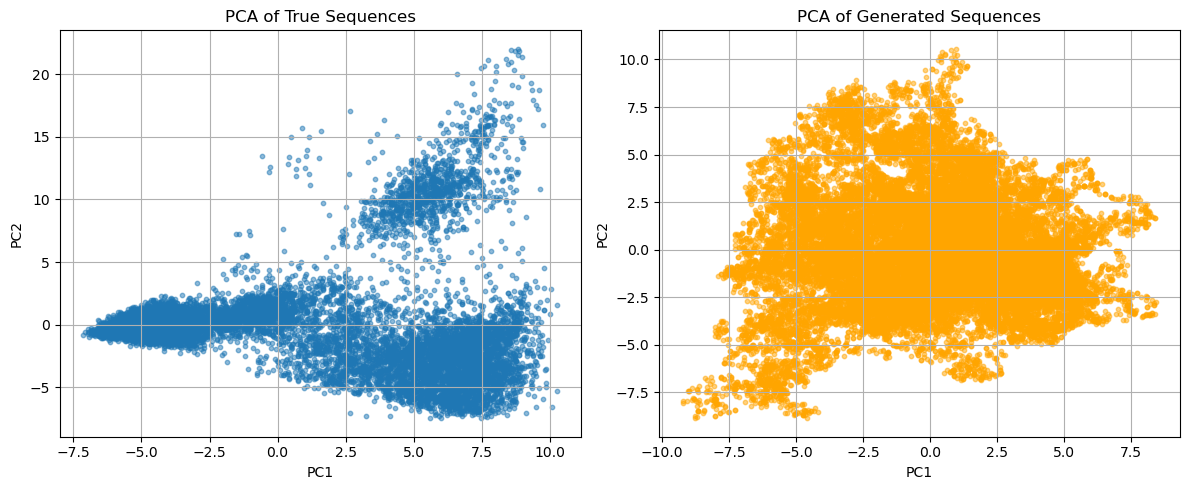

In [67]:

fig, axs = plt.subplots(1, 2, figsize=(12,5))

axs[0].scatter(true_pca[:,0], true_pca[:,1], alpha=0.5, s=10)
axs[0].set_title("PCA of True Sequences")
axs[0].set_xlabel("PC1")
axs[0].set_ylabel("PC2")
axs[0].grid(True)

axs[1].scatter(gen_pca[:,0], gen_pca[:,1], alpha=0.5, s=10, color='orange')
axs[1].set_title("PCA of Generated Sequences")
axs[1].set_xlabel("PC1")
axs[1].set_ylabel("PC2")
axs[1].grid(True)

plt.tight_layout()
plt.show()


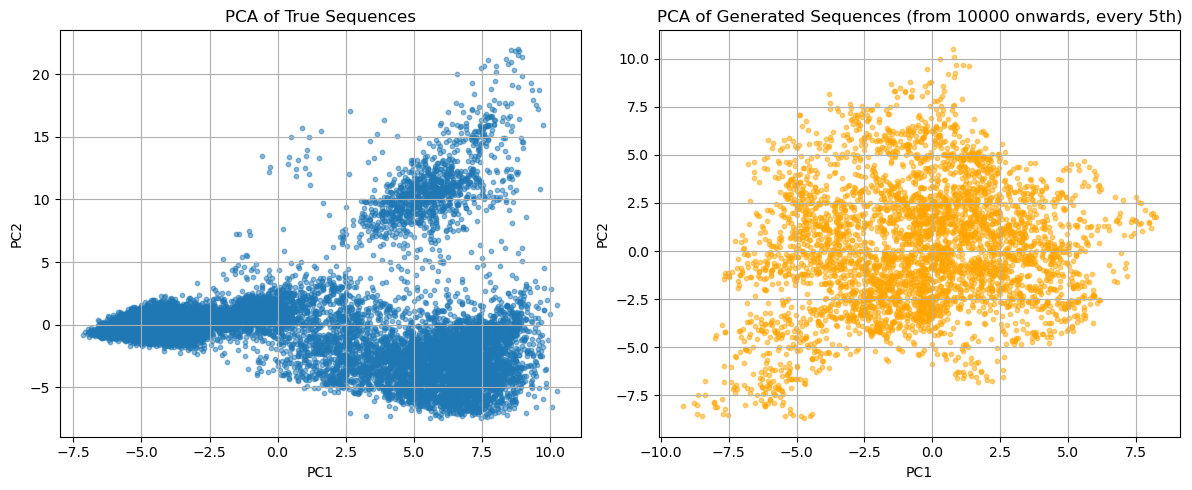

In [68]:
import matplotlib.pyplot as plt

# Assuming true_pca and gen_pca are already calculated PCA results

# Select from 10,000 to the end, and then take every 5th point
gen_pca_subset = gen_pca[10000::5]  # From 10,000 to end, taking every 5th point

# Create subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Plot PCA of True Sequences
axs[0].scatter(true_pca[:, 0], true_pca[:, 1], alpha=0.5, s=10)
axs[0].set_title("PCA of True Sequences")
axs[0].set_xlabel("PC1")
axs[0].set_ylabel("PC2")
axs[0].grid(True)

# Plot PCA of Generated Sequences (from 10,000 to end, every 5th sequence)
axs[1].scatter(gen_pca_subset[:, 0], gen_pca_subset[:, 1], alpha=0.5, s=10, color='orange')
axs[1].set_title("PCA of Generated Sequences (from 10000 onwards, every 5th)")
axs[1].set_xlabel("PC1")
axs[1].set_ylabel("PC2")
axs[1].grid(True)

# Adjust layout for better spacing
plt.tight_layout()

# Show the plots
plt.show()


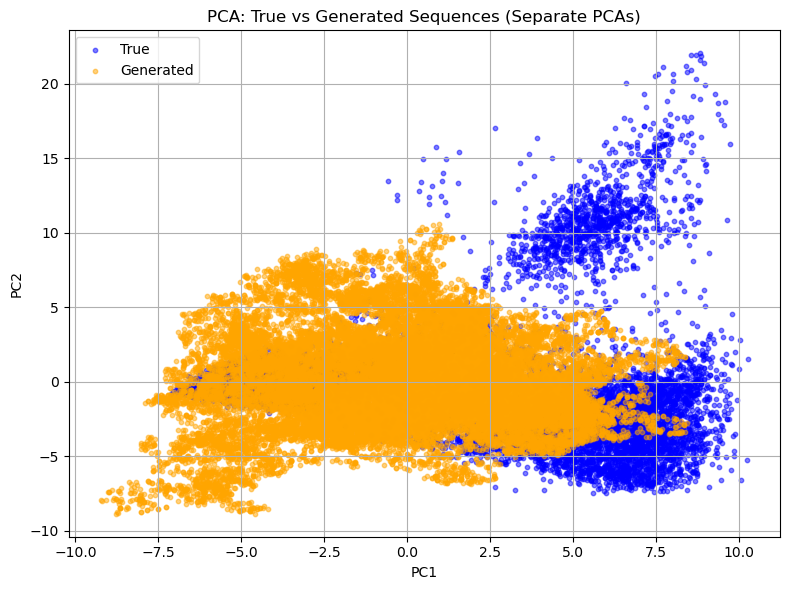

In [69]:
plt.figure(figsize=(8, 6))

# Plot True Sequences
plt.scatter(true_pca[:, 0], true_pca[:, 1], 
            alpha=0.5, s=10, label='True', color='blue')

# Plot Generated Sequences
plt.scatter(gen_pca[:, 0], gen_pca[:, 1], 
            alpha=0.5, s=10, label='Generated', color='orange')

plt.title("PCA: True vs Generated Sequences (Separate PCAs)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

(3739, 63, 21)


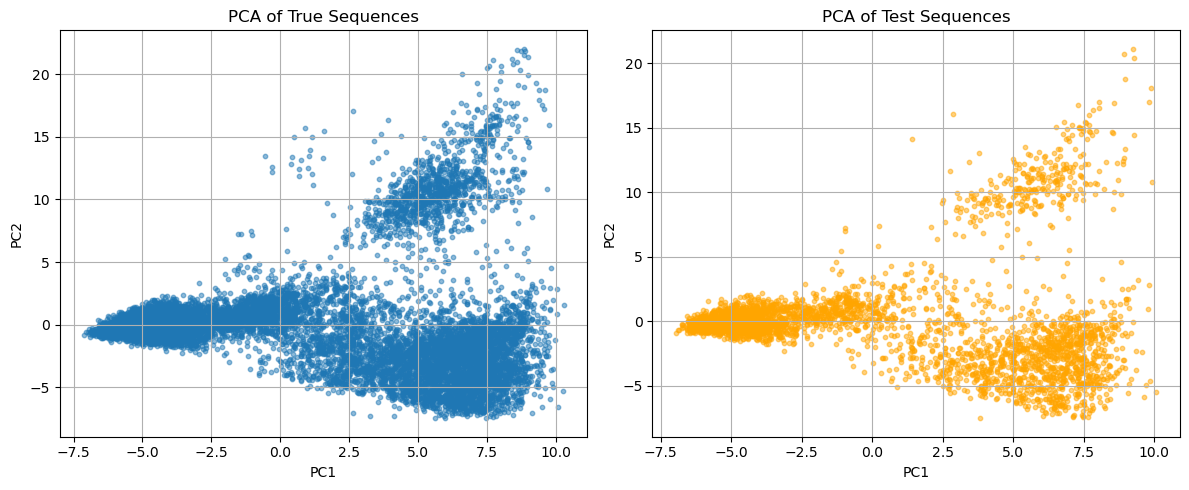

In [ ]:
# Define the file path
family = 'jdoms_bacteria_test2'
cwd = '/Users/marzioformica/Desktop/EPFL/Master/MA2/Labo/Attention-DCA-main'
filename = cwd + f'/CODE/DataAttentionDCA/jdoms/{family}.fasta'

letter_to_num = {
    'A': 1,  'B': 21, 'C': 2,  'D': 3,  'E': 4,
    'F': 5,  'G': 6,  'H': 7,  'I': 8,  'J': 21,
    'K': 9,  'L': 10, 'M': 11, 'N': 12, 'O': 21,
    'P': 13, 'Q': 14, 'R': 15, 'S': 16, 'T': 17,
    'U': 21, 'V': 18, 'W': 19, 'X': 21, 'Y': 20,
    '-': 21  # Gap symbol
}
# Initialize a list to store the sequences
test_sequences = []

# Parse the FASTA file using BioPython's SeqIO
for record in SeqIO.parse(filename, "fasta"):
    # Extract the sequence (and its header if needed)
    sequence = str(record.seq)  # convert to string
    numeric_seq = [letter_to_num[aa] for aa in sequence]
    test_sequences.append(numeric_seq)
    #print(f"Extracted sequence: {sequence[:50]}...")  # Display first 50 characters of each sequence

test_sequences = np.array(test_sequences)
test_sequences_one_hot = one_hot_seq_batch(test_sequences,max_pot=21)
print(np.shape(test_sequences_one_hot))

# 1. Flatten
test_flat = test_sequences_one_hot.reshape(test_sequences_one_hot.shape[0], -1)
true_flat = true_sequences_one_hot.reshape(true_sequences_one_hot.shape[0], -1)

# 2. Scale separately
scaler_true = StandardScaler()
true_scaled = scaler_true.fit_transform(true_flat)

scaler_gen = StandardScaler()
test_scaled = scaler_gen.fit_transform(test_flat)

# 3. PCA separately
pca_true = PCA(n_components=2)
true_pca = pca_true.fit_transform(true_scaled)

pca_test = PCA(n_components=2)
test_pca = pca_test.fit_transform(test_scaled)

fig, axs = plt.subplots(1, 2, figsize=(12,5))

axs[0].scatter(true_pca[:,0], true_pca[:,1], alpha=0.5, s=10)
axs[0].set_title("PCA of True Sequences")
axs[0].set_xlabel("PC1")
axs[0].set_ylabel("PC2")
axs[0].grid(True)

axs[1].scatter(test_pca[:,0], test_pca[:,1], alpha=0.5, s=10, color='orange')
axs[1].set_title("PCA of Test Sequences")
axs[1].set_xlabel("PC1")
axs[1].set_ylabel("PC2")
axs[1].grid(True)

plt.tight_layout()
plt.show()

In [ ]:
from scipy.spatial.distance import cdist

# Computes the Hamming distances between all pairs (scaled between 0 and 1)
# Multiply by sequence length to get actual number of differing positions
dist_matrix = cdist(gen_sequences, true_sequences, metric='hamming')  # shape: (10000, 14502)
min_distances = np.min(dist_matrix, axis=1) * gen_sequences.shape[1]

print(f"Avg Hamming distance to closest real sequence: {np.mean(min_distances):.2f}")

Avg Hamming distance to closest real sequence: 49.32


In [ ]:
from scipy.spatial.distance import cdist

# Computes the Hamming distances between all pairs (scaled between 0 and 1)
# Multiply by sequence length to get actual number of differing positions
dist_matrix = cdist(test_sequences, true_sequences, metric='hamming')  # shape: (10000, 14502)
min_distances = np.min(dist_matrix, axis=1) * test_sequences.shape[1]

print(f"Avg Hamming distance to closest real sequence: {np.mean(min_distances):.2f}")

Avg Hamming distance to closest real sequence: 2.78


In [ ]:
aa_pot = ['A', 'B', 'C',  'D',  'E', 'F',  'G',  'H',  'I',  'J', 'K',  'L', 'M', 'N', 'O','P', 'Q', 'R', 'S', 'T','U', 'V', 'W', 'X', 'Y', '-']
generate_sequence(aa_pot, Jtens)


/var/folders/dv/fpf7xq8j6yzfxjs7g9c_bbyc0000gn/T/ipykernel_28480/1596836997.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  return np.exp(sum)


[np.str_('D'),
 np.str_('J'),
 np.str_('A'),
 np.str_('B'),
 np.str_('B'),
 np.str_('X'),
 np.str_('U'),
 np.str_('N'),
 np.str_('B'),
 np.str_('B'),
 np.str_('I'),
 np.str_('X'),
 np.str_('-'),
 np.str_('X'),
 np.str_('X'),
 np.str_('X'),
 np.str_('X'),
 np.str_('O'),
 np.str_('C'),
 np.str_('X'),
 np.str_('R'),
 np.str_('A'),
 np.str_('X'),
 np.str_('I'),
 np.str_('X'),
 np.str_('Q'),
 np.str_('X'),
 np.str_('C'),
 np.str_('U'),
 np.str_('Y'),
 np.str_('R'),
 np.str_('U'),
 np.str_('K'),
 np.str_('U'),
 np.str_('W'),
 np.str_('U'),
 np.str_('K'),
 np.str_('X'),
 np.str_('Y'),
 np.str_('O'),
 np.str_('L'),
 np.str_('Y'),
 np.str_('J'),
 np.str_('D'),
 np.str_('-'),
 np.str_('X'),
 np.str_('O'),
 np.str_('B'),
 np.str_('X'),
 np.str_('O'),
 np.str_('E'),
 np.str_('T'),
 np.str_('V'),
 np.str_('U'),
 np.str_('A'),
 np.str_('E'),
 np.str_('I'),
 np.str_('V'),
 np.str_('T'),
 np.str_('D'),
 np.str_('O'),
 np.str_('T'),
 np.str_('Y'),
 np.str_('O')]

In [ ]:
aa_pot = ['A', 'B', 'C',  'D',  'E', 'F',  'G',  'H',  'I',  'J', 'K',  'L', 'M', 'N', 'O','P', 'Q', 'R', 'S', 'T','U', 'V', 'W', 'X', 'Y', '-']
amino_acids = generate_sequence(aa_pot, Jtens)
single_string = ''.join(amino_acids)

print(single_string)

/var/folders/dv/fpf7xq8j6yzfxjs7g9c_bbyc0000gn/T/ipykernel_28480/1596836997.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  return np.exp(sum)


CHBESYRAPPPSYMDSOOBXIDGRYSCAQKPD-IUDVDRYEFKUT-MFLSKXVLDTRKKKEKED


In [ ]:
letter_to_num = {
    'A': 1,  'B': 21, 'C': 2,  'D': 3,  'E': 4,
    'F': 5,  'G': 6,  'H': 7,  'I': 8,  'J': 21,
    'K': 9,  'L': 10, 'M': 11, 'N': 12, 'O': 21,
    'P': 13, 'Q': 14, 'R': 15, 'S': 16, 'T': 17,
    'U': 21, 'V': 18, 'W': 19, 'X': 21, 'Y': 20,
    '-': 21  # Gap symbol
}
# Initialize a list to store the sequences
ar_sequences = []

# Parse the FASTA file using BioPython's SeqIO
for _ in tqdm(range(1000)):
    # Extract the sequence (and its header if needed)
    sequence = ''.join(generate_sequence(aa_pot, Jtens))  # convert to string
    numeric_seq = [letter_to_num[aa] for aa in sequence]
    ar_sequences.append(numeric_seq)
    #print(f"Extracted sequence: {sequence[:50]}...")  # Display first 50 characters of each sequence

ar_sequences = np.array(ar_sequences)
ar_sequences_one_hot = one_hot_seq_batch(ar_sequences,max_pot=21)
print(np.shape(ar_sequences_one_hot))

  0%|          | 0/1000 [00:00<?, ?it/s]/var/folders/dv/fpf7xq8j6yzfxjs7g9c_bbyc0000gn/T/ipykernel_28480/1596836997.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  return np.exp(sum)
100%|██████████| 1000/1000 [08:54<00:00,  1.87it/s]

(1000, 64, 21)


In [ ]:
ar_sequences = np.array(ar_sequences)
ar_sequences_one_hot = one_hot_seq_batch(ar_sequences,max_pot=21)
print(np.shape(ar_sequences_one_hot))

(1000, 64, 21)


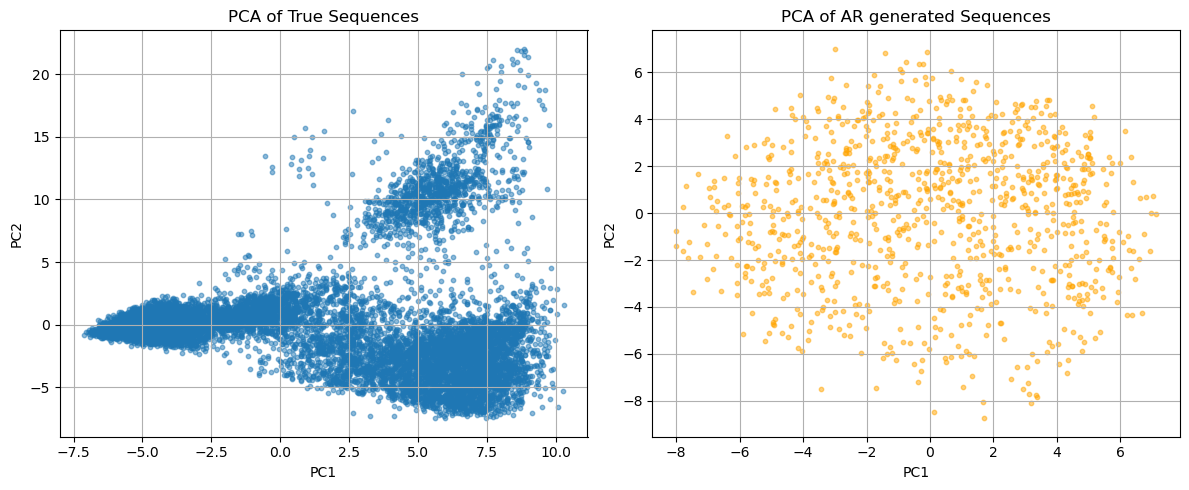

In [ ]:
ar_flat = ar_sequences_one_hot.reshape(ar_sequences_one_hot.shape[0], -1)
true_flat = true_sequences_one_hot.reshape(true_sequences_one_hot.shape[0], -1)

# 2. Scale separately
scaler_true = StandardScaler()
true_scaled = scaler_true.fit_transform(true_flat)

scaler_gen = StandardScaler()
ar_scaled = scaler_gen.fit_transform(ar_flat)

# 3. PCA separately
pca_true = PCA(n_components=2)
true_pca = pca_true.fit_transform(true_scaled)

pca_ar = PCA(n_components=2)
ar_pca = pca_ar.fit_transform(ar_scaled)

fig, axs = plt.subplots(1, 2, figsize=(12,5))

axs[0].scatter(true_pca[:,0], true_pca[:,1], alpha=0.5, s=10)
axs[0].set_title("PCA of True Sequences")
axs[0].set_xlabel("PC1")
axs[0].set_ylabel("PC2")
axs[0].grid(True)

axs[1].scatter(ar_pca[:,0], ar_pca[:,1], alpha=0.5, s=10, color='orange')
axs[1].set_title("PCA of AR generated Sequences")
axs[1].set_xlabel("PC1")
axs[1].set_ylabel("PC2")
axs[1].grid(True)

plt.tight_layout()
plt.show()